In [166]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from pathlib import Path
import math
from collections import Counter
import re

In [167]:
pd.set_option("display.max_rows", 20, "display.max_columns", 100)

In [168]:
# dialogue data for each character
dialogpath = Path('../project_data/movie_dialogue.tsv')
dialogue = pd.read_csv(dialogpath, sep = '\t')

dialogue.nunique()

mid           600
cid          2969
cname        1925
mname         600
gender          4
wordcount    1428
year           74
genres        283
comedy          2
thriller        2
drama           2
romance         2
lines        2969
dtype: int64

In [169]:
len(dialogue)

2969

In [170]:
# movie writer gender data
genderpath = Path('../data_processing_code/dialogue_writers_gender_with_counts.csv')
genderdf = pd.read_csv(genderpath, encoding = 'utf-8')
genderdf

,Unnamed: 0,mid,imdb_id,writer_ids,writer_names,writer_gender,num_of_female_writers,total_num_of_writers,all_female_writers
0,0,m0,tt0147800,"['nm0527581', 'nm0809006', 'nm0000636']","['Karen McCullah', 'Kirsten Smith', 'William S...","['F', 'F', 'M']",2,3,False
1,1,m1,tt0103594,['nm0097785'],['Rose Bosch'],['F'],1,1,True
2,2,m2,tt0179626,['nm0381273'],['John Herzfeld'],['M'],0,1,False
3,3,m3,tt0062622,"['nm0000040', 'nm0002009']","['Stanley Kubrick', 'Arthur C. Clarke']","['M', 'M']",0,2,False
4,4,m4,tt0083511,"['nm0006854', 'nm0001353', 'nm0343419', 'nm021...","['Roger Spottiswoode', 'Walter Hill', 'Larry G...","['M', 'M', 'M', 'M']",0,4,False
...,...,...,...,...,...,...,...,...,...
589,589,m610,tt0032138,"['nm0486538', 'nm0753249', 'nm0941138', 'nm000...","['Noel Langley', 'Florence Ryerson', 'Edgar Al...","['M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...",1,19,False
590,590,m611,tt0143145,"['nm0701031', 'nm0905498', 'nm0270761', 'nm000...","['Neal Purvis', 'Robert Wade', 'Bruce Feirstei...","['M', 'M', 'M', 'M']",0,4,False
591,591,m612,tt0409459,"['nm1733301', 'nm0371684', 'nm0874844']","['Dave Gibbons', 'David Hayter', 'Alex Tse']","['M', 'M', 'M']",0,3,False
592,592,m613,tt0295701,['nm0929186'],['Rich Wilkes'],['M'],0,1,False


In [171]:
# drop characters from movies with no imdb id / writer info
mids_no_imdb_id = ['m449', 'm310', 'm457', 'm488', 'm430', 'm605']


dialogue_no_missing_ids = dialogue[dialogue['mid'] != 'm449']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm310']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm457']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm488']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm430']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm605']

print(len(dialogue_no_missing_ids)) # 2947
dialogue_no_missing_ids.nunique() # should be 594 unique mids

2947


mid           594
cid          2947
cname        1915
mname         594
gender          4
wordcount    1421
year           74
genres        279
comedy          2
thriller        2
drama           2
romance         2
lines        2947
dtype: int64

In [172]:
dialogue_no_missing_ids = dialogue_no_missing_ids.reset_index()

In [173]:
dialogue_no_missing_ids.gender.unique()

array(['f', 'm', 'M', 'F'], dtype=object)

In [174]:
# make all gender labels lower case
dialogue_no_missing_ids.gender = dialogue_no_missing_ids.gender.str.lower()

In [175]:
dialogue_no_missing_ids.head(5)

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
0,0,m0,u0,BIANCA,10 things i hate about you,f,959,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...
1,1,m0,u2,CAMERON,10 things i hate about you,m,527,1999,"['comedy', 'romance']",True,False,False,True,"They do to! / She okay? / Wow / No / The ""real..."
2,2,m0,u4,JOEY,10 things i hate about you,m,278,1999,"['comedy', 'romance']",True,False,False,True,"Listen, I want to talk to you about the prom. ..."
3,3,m0,u5,KAT,10 things i hate about you,f,1217,1999,"['comedy', 'romance']",True,False,False,True,Perm? / It's just you. / What? To completely d...
4,4,m0,u6,MANDELLA,10 things i hate about you,f,157,1999,"['comedy', 'romance']",True,False,False,True,William - he asked me to meet him here. / Have...


In [176]:
# add cols for writer data -- add writer data to each char
dialogue_no_missing_ids['num_of_female_writers'] = ""
dialogue_no_missing_ids['total_writers'] = ""

In [177]:
# map movie id for each char to num of female writers and total num of writers 
for i, row in dialogue_no_missing_ids.iterrows():
    mid = dialogue_no_missing_ids.at[i, 'mid']
    match = genderdf[genderdf['mid'] == mid]
    f_num = match.iloc[0, 6] # grabs the num_of_female_writers col value
    total = match.iloc[0, 7] # grabs the total_num_of_writers col value
    dialogue_no_missing_ids.at[i, 'num_of_female_writers'] = f_num
    dialogue_no_missing_ids.at[i, 'total_writers'] = total

In [178]:
# split chars into test / training sets BEFORE doing feature selection

#shuffle chars 
dialogue_no_missing_ids = dialogue_no_missing_ids.sample(frac = 1)
dialogue_no_missing_ids.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1244,1247,m323,u4847,POWELL,die hard,m,516,1988,"['action', 'crime', 'thriller']",False,True,False,False,Bullshit. / Roy? / I got it. But you can tell...,0,3
2458,2472,m556,u8197,MULDER,the x files,m,1525,1998,"['crime', 'horror', 'mystery', 'sci-fi', 'thri...",False,True,False,False,Sorry. Don't have one. / Does what? / What do ...,0,2
1968,1981,m462,u6896,ANNA,notting hill,f,1900,1999,"['comedy', 'romance']",True,False,False,True,Lovely to meet you. / I'm a vegetarian. / I wo...,0,1
144,144,m124,u1891,CHANG,lost horizon,m,1177,1937,"['adventure', 'drama', 'fantasy', 'mystery']",False,False,True,False,Yes. / Yes. Those are our own people. They nev...,0,3
1782,1785,m427,u6416,ZEKE,love & basketball,m,687,2000,"['drama', 'romance', 'sport']",False,False,True,True,I'd love for him to get a good education. Tha...,1,1


In [179]:
# select training data
trainchars = dialogue_no_missing_ids.iloc[0 : 1473, : ]
trainchars.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1244,1247,m323,u4847,POWELL,die hard,m,516,1988,"['action', 'crime', 'thriller']",False,True,False,False,Bullshit. / Roy? / I got it. But you can tell...,0,3
2458,2472,m556,u8197,MULDER,the x files,m,1525,1998,"['crime', 'horror', 'mystery', 'sci-fi', 'thri...",False,True,False,False,Sorry. Don't have one. / Does what? / What do ...,0,2
1968,1981,m462,u6896,ANNA,notting hill,f,1900,1999,"['comedy', 'romance']",True,False,False,True,Lovely to meet you. / I'm a vegetarian. / I wo...,0,1
144,144,m124,u1891,CHANG,lost horizon,m,1177,1937,"['adventure', 'drama', 'fantasy', 'mystery']",False,False,True,False,Yes. / Yes. Those are our own people. They nev...,0,3
1782,1785,m427,u6416,ZEKE,love & basketball,m,687,2000,"['drama', 'romance', 'sport']",False,False,True,True,I'd love for him to get a good education. Tha...,1,1


In [180]:
# select testing data
testchars = dialogue_no_missing_ids.iloc[1473 :, : ]
testchars.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1397,1400,m353,u5327,TITA,five easy pieces,f,607,1970,['drama'],False,False,True,False,"Bye, Robert. / But what about me? / You were g...",1,2
2633,2647,m59,u912,MR. HAND,fast times at ridgemont high,m,306,1982,"['comedy', 'drama', 'romance']",True,False,True,True,"Aloha, Spicoli. / Don't worry, Spicoli. You'll...",0,1
2462,2476,m557,u8207,MIRIAM,the cell,f,515,2000,"['drama', 'fantasy', 'horror', 'sci-fi', 'thri...",False,True,True,False,...give a kiss to Edward. / I'll come by tomor...,0,1
878,878,m256,u3868,DEUTSCH,barton fink,m,170,1991,"['drama', 'mystery', 'thriller']",False,True,True,False,"All right, forget the heads. Where's Mundt, Fi...",0,2
1493,1496,m372,u5594,KAREN,goodfellas,f,577,1990,"['crime', 'drama', 'thriller']",False,True,True,False,What about the schools? / I got scared. / I go...,0,2


In [181]:
# feature selection -- build feature vocabulary ONLY using training data
# using doc frequency (count of how many docs / char lines a word appears in), instead of simply overall word count

vocab = Counter()

stopwords = ['the', 'of', 'and', 'she', 'her', 'he','him']

for char in trainchars['lines']:
    words = re.split('\W', char)
    lowercase = [w.lower() for w in words] 
    unique_words = set([w for w in lowercase if len(w) > 1])  # get rid of one-letter words
    for w in unique_words:
        if w not in stopwords and not w.isdigit(): # don't include numbers and stopwords
            vocab[w.lower()] += 1
        
vocab = vocab.most_common(5000) # returns pairs of keys and counts for words with highest counts


In [182]:
wordfeatures = [x[0] for x in vocab]   
docfreqs = [x[1] for x in vocab]

In [183]:
# create doc term matrix for training data

vectorizer = CountVectorizer(vocabulary = wordfeatures) 

train_char_index = trainchars.index

sparse_counts = vectorizer.fit_transform(trainchars['lines'])
                                                            
train_char_word_counts = pd.DataFrame(sparse_counts.toarray(), index = train_char_index,
                            columns = vectorizer.get_feature_names())
train_char_word_counts.head()

,you,to,it,that,what,in,is,me,this,for,do,don,have,not,know,re,we,be,on,but,no,was,your,with,can,my,are,all,just,there,like,so,about,they,get,if,here,out,ll,up,how,at,one,think,now,ve,got,go,right,want,...,finance,roommate,urgent,fog,bait,suspicion,effective,declared,spiritual,tin,stink,balloon,luke,hangs,entered,essence,phase,associate,homosexual,cloak,sickness,establish,margaret,greek,projects,catherine,ounce,brutal,morals,lo,bold,auto,thieves,insignificant,farther,inspired,excellency,probe,discussing,useless,sample,martini,lamp,almighty,fuckers,resistance,lydia,chew,recommended,retire
1244,27,12,8,3,6,10,1,1,2,3,5,6,0,3,8,4,6,4,6,5,1,4,2,2,2,3,3,2,2,4,1,4,2,4,0,4,2,2,3,4,2,0,3,6,1,1,7,0,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2458,81,45,24,23,40,20,12,26,21,12,7,9,10,10,11,19,16,6,11,5,4,16,7,10,9,5,12,2,7,5,6,1,9,22,5,5,7,6,5,0,8,4,2,6,2,8,6,3,4,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1968,74,49,44,32,15,35,20,15,12,13,12,12,11,8,13,9,7,20,4,17,27,18,9,18,6,10,6,8,15,8,7,11,15,14,7,7,4,3,10,6,8,5,6,6,6,12,10,7,7,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
144,46,23,26,13,3,24,19,8,4,10,7,1,13,8,4,1,19,7,5,7,13,8,9,3,2,5,10,3,0,7,5,9,2,6,1,1,13,2,1,1,3,3,5,1,5,4,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1782,28,26,11,11,5,5,2,9,9,5,1,9,5,6,5,4,3,3,5,9,5,4,14,5,5,8,0,0,7,4,6,2,4,0,9,0,0,3,5,3,3,5,4,0,2,0,4,3,4,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [184]:
# create doc term matrix for testing data

vectorizer = CountVectorizer(vocabulary = wordfeatures)

test_char_index = testchars.index # preserve indexes to map back to metadata in chars df

sparse_counts = vectorizer.fit_transform(testchars['lines'])
                                                            
test_char_word_counts = pd.DataFrame(sparse_counts.toarray(), index = test_char_index,
                            columns = vectorizer.get_feature_names())
test_char_word_counts.head()
len(test_char_word_counts)

1474

In [185]:
# calculate word freq from word counts and factor out dialogue length
train_dwordcount = trainchars['wordcount']
test_dwordcount = testchars['wordcount']
train_dwordcount


1244     516
2458    1525
1968    1900
144     1177
1782     687
        ... 
858     1224
468      310
2104     341
101     1507
2827    1075
Name: wordcount, Length: 1473, dtype: int64

In [186]:
# gives us relative word freq for each char 
train_wordfreqs = train_char_word_counts.divide(train_dwordcount, axis = 'rows')
test_wordfreqs = test_char_word_counts.divide(test_dwordcount, axis = 'rows')
len(train_wordfreqs)

1473

In [187]:
train_wordfreqs

,you,to,it,that,what,in,is,me,this,for,do,don,have,not,know,re,we,be,on,but,no,was,your,with,can,my,are,all,just,there,like,so,about,they,get,if,here,out,ll,up,how,at,one,think,now,ve,got,go,right,want,...,finance,roommate,urgent,fog,bait,suspicion,effective,declared,spiritual,tin,stink,balloon,luke,hangs,entered,essence,phase,associate,homosexual,cloak,sickness,establish,margaret,greek,projects,catherine,ounce,brutal,morals,lo,bold,auto,thieves,insignificant,farther,inspired,excellency,probe,discussing,useless,sample,martini,lamp,almighty,fuckers,resistance,lydia,chew,recommended,retire
1244,0.052326,0.023256,0.015504,0.005814,0.011628,0.019380,0.001938,0.001938,0.003876,0.005814,0.009690,0.011628,0.000000,0.005814,0.015504,0.007752,0.011628,0.007752,0.011628,0.009690,0.001938,0.007752,0.003876,0.003876,0.003876,0.005814,0.005814,0.003876,0.003876,0.007752,0.001938,0.007752,0.003876,0.007752,0.000000,0.007752,0.003876,0.003876,0.005814,0.007752,0.003876,0.000000,0.005814,0.011628,0.001938,0.001938,0.013566,0.000000,0.001938,0.003876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2458,0.053115,0.029508,0.015738,0.015082,0.026230,0.013115,0.007869,0.017049,0.013770,0.007869,0.004590,0.005902,0.006557,0.006557,0.007213,0.012459,0.010492,0.003934,0.007213,0.003279,0.002623,0.010492,0.004590,0.006557,0.005902,0.003279,0.007869,0.001311,0.004590,0.003279,0.003934,0.000656,0.005902,0.014426,0.003279,0.003279,0.004590,0.003934,0.003279,0.000000,0.005246,0.002623,0.001311,0.003934,0.001311,0.005246,0.003934,0.001967,0.002623,0.003934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1968,0.038947,0.025789,0.023158,0.016842,0.007895,0.018421,0.010526,0.007895,0.006316,0.006842,0.006316,0.006316,0.005789,0.004211,0.006842,0.004737,0.003684,0.010526,0.002105,0.008947,0.014211,0.009474,0.004737,0.009474,0.003158,0.005263,0.003158,0.004211,0.007895,0.004211,0.003684,0.005789,0.007895,0.007368,0.003684,0.003684,0.002105,0.001579,0.005263,0.003158,0.004211,0.002632,0.003158,0.003158,0.003158,0.006316,0.005263,0.003684,0.003684,0.002632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.039082,0.019541,0.022090,0.011045,0.002549,0.020391,0.016143,0.006797,0.003398,0.008496,0.005947,0.000850,0.011045,0.006797,0.003398,0.000850,0.016143,0.005947,0.004248,0.005947,0.011045,0.006797,0.007647,0.002549,0.001699,0.004248,0.008496,0.002549,0.000000,0.005947,0.004248,0.007647,0.001699,0.005098,0.000850,0.000850,0.011045,0.001699,0.000850,0.000850,0.002549,0.002549,0.004248,0.000850,0.004248,0.003398,0.000000,0.001699,0.001699,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1782,0.040757,0.037846,0.016012,0.016012,0.007278,0.007278,0.002911,0.013100,0.013100,0.007278,0.001456,0.013100,0.007278,0.008734,0.007278,0.005822,0.004367,0.004367,0.007278,0.013100,0.007278,0.005822,0.020378,0.007278,0.007278,0.011645,0.000000,0.000000,0.010189,0.005822,0.008734,0.002911,0.005822,0.000000,0.013100,0.000000,0.000000,0.004367,0.007278,0.004367,0.004367,0.007278,0.005822,0.000000,0.002911,0.000000,0.005822,0.004367,0.005822,0.002911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,..

In [188]:
test_wordfreqs

,you,to,it,that,what,in,is,me,this,for,do,don,have,not,know,re,we,be,on,but,no,was,your,with,can,my,are,all,just,there,like,so,about,they,get,if,here,out,ll,up,how,at,one,think,now,ve,got,go,right,want,...,finance,roommate,urgent,fog,bait,suspicion,effective,declared,spiritual,tin,stink,balloon,luke,hangs,entered,essence,phase,associate,homosexual,cloak,sickness,establish,margaret,greek,projects,catherine,ounce,brutal,morals,lo,bold,auto,thieves,insignificant,farther,inspired,excellency,probe,discussing,useless,sample,martini,lamp,almighty,fuckers,resistance,lydia,chew,recommended,retire
1397,0.049423,0.032949,0.021417,0.019769,0.008237,0.006590,0.006590,0.011532,0.004942,0.009885,0.008237,0.011532,0.013180,0.014827,0.008237,0.004942,0.003295,0.003295,0.008237,0.004942,0.011532,0.008237,0.003295,0.008237,0.009885,0.006590,0.006590,0.006590,0.006590,0.004942,0.001647,0.011532,0.008237,0.001647,0.006590,0.000000,0.000000,0.001647,0.004942,0.004942,0.000000,0.003295,0.000000,0.009885,0.000000,0.003295,0.000000,0.001647,0.003295,0.003295,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,0.075163,0.026144,0.000000,0.009804,0.013072,0.016340,0.000000,0.003268,0.009804,0.019608,0.009804,0.009804,0.003268,0.000000,0.000000,0.009804,0.003268,0.006536,0.013072,0.000000,0.000000,0.000000,0.013072,0.003268,0.003268,0.022876,0.006536,0.006536,0.013072,0.003268,0.006536,0.003268,0.003268,0.000000,0.003268,0.009804,0.019608,0.003268,0.013072,0.000000,0.000000,0.000000,0.000000,0.006536,0.009804,0.006536,0.003268,0.000000,0.006536,0.003268,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2462,0.036893,0.033010,0.009709,0.019417,0.011650,0.013592,0.007767,0.005825,0.015534,0.005825,0.000000,0.007767,0.005825,0.001942,0.005825,0.011650,0.011650,0.003883,0.000000,0.009709,0.001942,0.005825,0.005825,0.003883,0.001942,0.001942,0.001942,0.007767,0.000000,0.003883,0.000000,0.001942,0.009709,0.003883,0.003883,0.007767,0.003883,0.003883,0.001942,0.001942,0.000000,0.001942,0.001942,0.000000,0.001942,0.005825,0.000000,0.003883,0.001942,0.009709,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
878,0.058824,0.023529,0.017647,0.011765,0.023529,0.011765,0.005882,0.000000,0.000000,0.000000,0.000000,0.000000,0.005882,0.005882,0.000000,0.000000,0.005882,0.000000,0.005882,0.000000,0.005882,0.000000,0.005882,0.005882,0.000000,0.005882,0.005882,0.011765,0.000000,0.005882,0.000000,0.011765,0.005882,0.005882,0.000000,0.000000,0.005882,0.011765,0.005882,0.005882,0.011765,0.000000,0.000000,0.000000,0.005882,0.000000,0.005882,0.005882,0.005882,0.005882,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1493,0.039861,0.038128,0.013865,0.010399,0.022530,0.010399,0.000000,0.015598,0.003466,0.003466,0.013865,0.017331,0.005199,0.000000,0.010399,0.012132,0.003466,0.003466,0.006932,0.003466,0.006932,0.003466,0.005199,0.006932,0.003466,0.005199,0.005199,0.006932,0.001733,0.001733,0.003466,0.001733,0.006932,0.013865,0.001733,0.006932,0.006932,0.006932,0.001733,0.012132,0.001733,0.008666,0.001733,0.000000,0.001733,0.003466,0.017331,0.001733,0.001733,0.010399,...,0.000000,0.0,0.001733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...

In [189]:
# add dialogue word count col for each character 
train_wordfreqs['#dwordcount'] = train_dwordcount
test_wordfreqs['#dwordcount'] = test_dwordcount


In [190]:
# get y predictions for test and training sets
train_y = (trainchars['gender'] == 'm').astype(int)
test_y = (testchars['gender'] == 'm').astype(int)

In [191]:
# scale X matrices for training data
# normalizes cols -- col = (col-col.mean) / col.std (like a z score)
trainscaler = StandardScaler()
trainXscaled = trainscaler.fit_transform(train_wordfreqs)
trainXscaled = pd.DataFrame(trainXscaled, columns = train_wordfreqs.columns)
trainXscaled.head()

,you,to,it,that,what,in,is,me,this,for,do,don,have,not,know,re,we,be,on,but,no,was,your,with,can,my,are,all,just,there,like,so,about,they,get,if,here,out,ll,up,how,at,one,think,now,ve,got,go,right,want,...,roommate,urgent,fog,bait,suspicion,effective,declared,spiritual,tin,stink,balloon,luke,hangs,entered,essence,phase,associate,homosexual,cloak,sickness,establish,margaret,greek,projects,catherine,ounce,brutal,morals,lo,bold,auto,thieves,insignificant,farther,inspired,excellency,probe,discussing,useless,sample,martini,lamp,almighty,fuckers,resistance,lydia,chew,recommended,retire,#dwordcount
0,0.257002,-0.224891,-0.629579,-1.264550,-0.060205,1.682182,-1.261056,-1.175531,-0.722869,-0.305071,0.504857,0.659496,-1.397670,-0.117158,1.754861,0.082035,0.309438,0.411116,1.357085,1.087769,-0.865638,0.307335,-0.481155,-0.366393,-0.425208,-0.127380,0.083243,-0.267381,-0.270539,0.865306,-0.679093,0.849352,-0.135025,0.412321,-1.182981,1.121270,-0.024134,-0.084179,0.321396,1.249145,0.090637,-1.137940,0.837959,2.551075,-0.385089,-0.462508,2.561863,-0.928037,-0.372676,0.105528,...,-0.051183,-0.063931,-0.065044,-0.067016,-0.068847,-0.067613,-0.063021,-0.057519,-0.06171,-0.060713,-0.056386,-0.063718,-0.054424,-0.055388,-0.066591,-0.05691,-0.056883,-0.062914,-0.052716,-0.070255,-0.060737,-0.058,-0.058329,-0.06313,-0.057554,-0.052991,-0.054931,-0.055272,-0.060156,-0.063791,-0.066776,-0.062868,-0.061852,-0.064153,-0.053492,-0.049957,-0.0662,-0.055122,-0.063936,-0.070667,-0.06171,-0.074891,-0.059274,-0.057465,-0.062105,-0.064539,-0.05829,-0.058742,-0.062154,-0.425328
1,0.300544,0.503817,-0.602853,0.091684,2.045176,0.510496,-0.212836,1.066513,1.144202,0.168103,-0.530250,-0.354574,-0.052180,0.039995,0.070938,0.962248,0.167842,-0.503008,0.303803,-0.526528,-0.727934,0.854240,-0.360222,0.360856,0.032096,-0.579279,0.541192,-0.987476,-0.097337,-0.327697,-0.209141,-0.945322,0.411639,1.615479,-0.305824,-0.231860,0.181426,-0.067758,-0.319587,-1.121211,0.521920,-0.217282,-0.634643,0.150264,-0.602101,0.529256,0.082254,-0.359251,-0.173995,0.121150,...,-0.051183,-0.063931,-0.065044,-0.067016,-0.068847,-0.067613,-0.063021,-0.057519,-0.06171,-0.060713,-0.056386,-0.063718,-0.054424,-0.055388,-0.066591,-0.05691,-0.056883,-0.062914,-0.052716,-0.070255,-0.060737,-0.058,-0.058329,-0.06313,-0.057554,-0.052991,-0.054931,-0.055272,-0.060156,-0.063791,-0.066776,-0.062868,-0.061852,-0.064153,-0.053492,-0.049957,-0.0662,-0.055122,-0.063936,-0.070667,-0.06171,-0.074891,-0.059274,-0.057465,-0.062105,-0.064539,-0.05829,-0.058742,-0.062154,0.846364
2,-0.481125,0.070404,0.245271,0.349254,-0.598485,1.502870,0.256844,-0.291729,-0.262481,-0.068322,-0.179997,-0.281232,-0.209744,-0.456111,-0.004417,-0.481781,-0.680607,1.075457,-0.914829,0.900800,1.601605,0.651013,-0.335385,1.151814,-0.587317,-0.225557,-0.508679,-0.173440,0.704070,-0.079179,-0.268041,0.353032,0.949513,0.343185,-0.197333,-0.109192,-0.533779,-0.729433,0.182140,-0.155602,0.195963,-0.214253,-0.030745,-0.092059,0.037468,0.850025,0.424334,0.137189,0.133833,-0.227018,...,-0.051183,-0.063931,-0.065044,-0.067016,-0.068847,-0.067613,-0.063021,-0.057519,-0.06171,-0.060713,-0.056386,-0.063718,-0.054424,-0.055388,-0.066591,-0.05691,-0.056883,-0.062914,-0.052716,-0.070255,-0.060737,-0.058,-0.058329,-0.06313,-0.057554,-0.052991,-0.054931,-0.055272,-0.060156,-0.063791,-0.066776,-0.062868,-0.061852,-0.064153,-0.053492,-0.049957,-0.0662,-0.055122,-0.063936,-0.070667,-0.06171,-0.074891,-0.059274,-0.057465,-0.062105,-0.064539,-0.05829,-0.058742,-0.062154,1.318994
3,-0.473674,-0.657823,0.123218,-0.499061,-1.369300,1.871254,1.249489,-0.454609,-0.812971,0.312554,-0.254785,-1.249240,0.868629,0.090638,-0.703848,-1.208683,0.872134,-0.021009,-0.403593,0.145413,0.965221,0.116708,0.157312,-0.726332,-0.916616,-0.406488,0.680996,-0.640028,-1.210517,0.384021,-0.135307,0.822701,-0.722457,-0.066151,-0.955681,-0.966639,2.039266,-0.695643,-0.933721,-0.861418,-0.327166,-0.243290,0.325819,-0.812375,0.415093,-0.024631,-0.930659,-0.436732,-0.441927,-0.930271

In [192]:
# scale X matrices for testing data
testscaler = StandardScaler()
testXscaled = testscaler.fit_transform(test_wordfreqs)
testXscaled = pd.DataFrame(testXscaled, columns = test_wordfreqs.columns)

In [193]:
# simple model

# train model
logist = LogisticRegression(C = .1, max_iter = 1000) 
logist.fit(trainXscaled, train_y)

# test model
predictions = logist.predict(testXscaled)
sum(predictions == test_y) / len(predictions)

0.7340569877883311

In [194]:
# more accurate refelction of performance of model
f1_score(test_y, predictions)

0.815962441314554

In [195]:
# balance of classes -- m vs. f
dialogue_no_missing_ids.gender.value_counts()

m    2006
f     941
Name: gender, dtype: int64

In [196]:
# handling imbalanced classes
# weight classes inversely to frequency -- female char error counts more

# train
logist = LogisticRegression(C = .1, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test
predictions = logist.predict(testXscaled)
f1_score(test_y, predictions)

0.807710843373494

In [197]:
# cross validation -- select best C parameter using training data
mean_f1_scores = {}

for c_param in [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]:
    logist = LogisticRegression(C = c_param, max_iter = 1000, class_weight = 'balanced') 
    results = cross_validate(logist, trainXscaled, train_y, cv = 5, scoring = 'f1')
    print('C parameter:', c_param)
    print('Mean f1:', np.mean(results['test_score']))
    mean_f1_scores[c_param] = np.mean(results['test_score'])
    print()

best_c = 0
best_mean = -1

for t in mean_f1_scores.items():
    if t[1] > best_mean:
        best_c = t[0]
        best_mean = t[1]

print(best_c)

C parameter: 1e-05
Mean f1: 0.8116047251911265

C parameter: 0.0001
Mean f1: 0.8176916497367246

C parameter: 0.001
Mean f1: 0.8238980774833979

C parameter: 0.01
Mean f1: 0.8216670363361007

C parameter: 0.1
Mean f1: 0.8167780912753493

C parameter: 1
Mean f1: 0.8144077639852771

C parameter: 10
Mean f1: 0.8106939894005276

C parameter: 100
Mean f1: 0.8059718273187549

C parameter: 1000
Mean f1: 0.8061586225607209

0.001


In [198]:
# use best C param to train whole training set
# train
logist = LogisticRegression(C = best_c, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test
predictions = logist.predict(testXscaled)
accuracy = f1_score(test_y, predictions)
print("Accuracy for entire training set is: ", accuracy)

Accuracy for entire training set is:  0.8131115459882583


In [199]:
# need to split test data -- into groups by writer gender (at least 1 female vs. no female writers)

testchars.head()
test_chars_f = testchars[testchars['num_of_female_writers'] >= 1]
test_chars_no_f = testchars[testchars['num_of_female_writers'] == 0]

In [200]:
# test accuracy on chars from movies w/ at least 1 female writer

# separate out test set rows from freqs w/ at least 1 female writer
testfreqs_female = test_wordfreqs.loc[test_chars_f.index, :]
test_y_f = (test_chars_f['gender'][:] == 'm').astype(int)

# scale test data w/ atleast 1 female writer
testscaler = StandardScaler()
testXscaled_f = testscaler.fit_transform(testfreqs_female)
testXscaled_f = pd.DataFrame(testXscaled_f, columns = testfreqs_female.columns)

In [201]:
# train
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test w/ testXscaled_f
predictions = logist.predict(testXscaled_f)
accuracy = f1_score(test_y_f, predictions)
print("Accuracy for female writers is: ", accuracy)

Accuracy for female writers is:  0.7290322580645161


In [202]:
# test accuracy on chars from movies w/ no female writers

# separate out test set rows from freqs w/ no female writers
testfreqs_no_female =test_wordfreqs.loc[test_chars_no_f.index, :]
test_y_no_f = (test_chars_no_f['gender'][:] == 'm').astype(int)

# scale test data w/ no female writers
testscaler = StandardScaler()
testXscaled_no_f = testscaler.fit_transform(testfreqs_no_female)
testXscaled_no_f = pd.DataFrame(testfreqs_no_female, columns = testfreqs_no_female.columns)

In [203]:
# train
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test w/ testXscaled_f
predictions = logist.predict(testXscaled_no_f)
accuracy = f1_score(test_y_no_f, predictions)
print("Accuracy for no female writers is: ", accuracy)

Accuracy for no female writers is:  0.821173104434907


In [204]:
# classifier model predictive features
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)
coefficients = [x for x in zip(logist.coef_[0], vectorizer.get_feature_names())]

In [205]:
coefficients.sort()

In [206]:
coefficients[0:25] # female

[(-0.08500776733655613, 'husband'),
 (-0.08351444926096384, 'fun'),
 (-0.08120043849071448, 'love'),
 (-0.0803798022140931, 'silly'),
 (-0.0782463505766054, 'oh'),
 (-0.07155025363139782, 'god'),
 (-0.07004432657435955, 'johnny'),
 (-0.06898964304966913, 'raise'),
 (-0.06865409582493873, 'goodbye'),
 (-0.0675401301275179, 'sick'),
 (-0.0672767640077373, 'laundry'),
 (-0.06592593016222253, 'library'),
 (-0.06583718034062802, 'creeps'),
 (-0.06539150590742598, 'so'),
 (-0.06470137583503607, 'sweetie'),
 (-0.06440710820318606, 'brutal'),
 (-0.0643585148968523, 'me'),
 (-0.06430555426199236, 'burke'),
 (-0.06288424533006418, 'such'),
 (-0.061950114508672265, 'shocking'),
 (-0.06138173797391513, 'honey'),
 (-0.05916166497338698, 'bruce'),
 (-0.05854323570421076, 'postcard'),
 (-0.05823970509638389, 'you'),
 (-0.058088986842939956, 'fuss')]

In [207]:
coefficients[-25:] # male

[(0.05053959974173926, 'limits'),
 (0.050798184201637044, 'up'),
 (0.051209114048769204, 'thirty'),
 (0.051272826641748016, 'monsters'),
 (0.05172152389856844, 'pleasure'),
 (0.052119793144901505, 'got'),
 (0.052147268212500514, 'kid'),
 (0.0527118892426001, 'fuckin'),
 (0.05305674044703467, 'belong'),
 (0.05335467776416393, 'strings'),
 (0.05365981217574599, 'history'),
 (0.053744392100294316, 'hell'),
 (0.05459203062127224, 'slap'),
 (0.05470326178157133, 'here'),
 (0.05480182957116039, 'talking'),
 (0.055252810761034755, 'country'),
 (0.05618290929974628, 'we'),
 (0.05808978010960351, 'right'),
 (0.06036509456109871, 'look'),
 (0.06151637744717547, 'situation'),
 (0.06223470624673475, 'man'),
 (0.06537307577983197, 'listen'),
 (0.06613839292232276, 'nah'),
 (0.06692433695740498, 'running'),
 (0.07898725062011196, 'hey')]

# Visualizations

In [208]:
dialogue_no_missing_ids.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1244,1247,m323,u4847,POWELL,die hard,m,516,1988,"['action', 'crime', 'thriller']",False,True,False,False,Bullshit. / Roy? / I got it. But you can tell...,0,3
2458,2472,m556,u8197,MULDER,the x files,m,1525,1998,"['crime', 'horror', 'mystery', 'sci-fi', 'thri...",False,True,False,False,Sorry. Don't have one. / Does what? / What do ...,0,2
1968,1981,m462,u6896,ANNA,notting hill,f,1900,1999,"['comedy', 'romance']",True,False,False,True,Lovely to meet you. / I'm a vegetarian. / I wo...,0,1
144,144,m124,u1891,CHANG,lost horizon,m,1177,1937,"['adventure', 'drama', 'fantasy', 'mystery']",False,False,True,False,Yes. / Yes. Those are our own people. They nev...,0,3
1782,1785,m427,u6416,ZEKE,love & basketball,m,687,2000,"['drama', 'romance', 'sport']",False,False,True,True,I'd love for him to get a good education. Tha...,1,1


In [209]:
dialogue_no_missing_ids.num_of_female_writers.value_counts()

0    2476
1     394
2      61
3      16
Name: num_of_female_writers, dtype: int64

Text(0, 0.5, '')

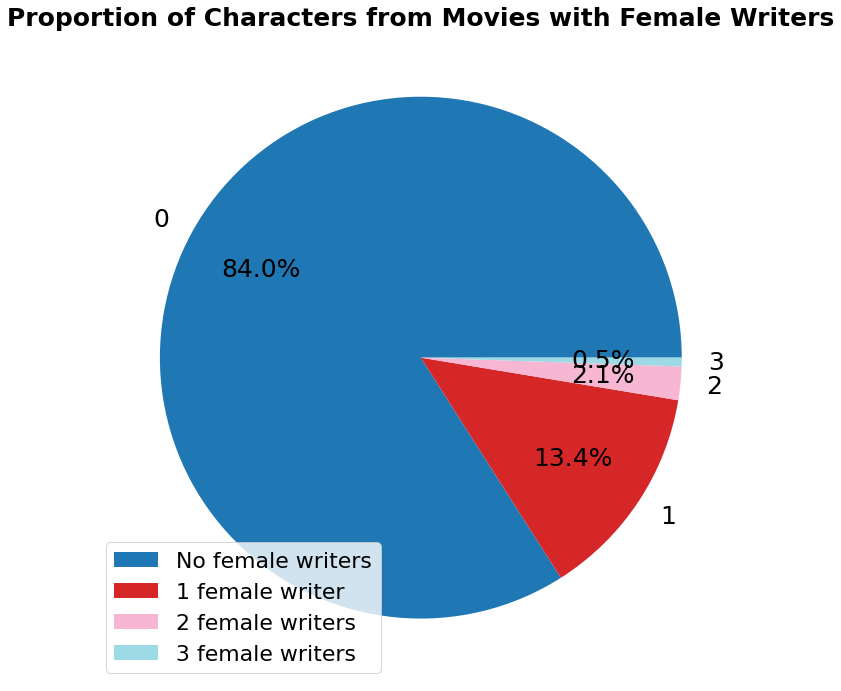

In [210]:
piechart = dialogue_no_missing_ids.num_of_female_writers.value_counts().plot(kind = 'pie', 
                                                              figsize=(12,12), 
                                                              autopct = "%.1f%%", 
                                                              pctdistance = 0.7,
                                                              colormap = 'tab20',
                                                              textprops={'fontsize': 25})
                                                         
                                                  
piechart.set_title('Proportion of Characters from Movies with Female Writers', fontweight="bold", size=25)
labels = ['No female writers', '1 female writer', '2 female writers', '3 female writers']
piechart.legend(labels,loc = 'lower left', fontsize = 22)
piechart.set_ylabel('')